In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as pd
from pygem_eb.processing.plotting_fxns import *
from objectives import *
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
longdict = {'A':{},'B':{},'D':{}}
for set in range(4):
    for run in range(3):
        ds,s,e = getds(f'../Output/EB/11_11_0/grid_11_11_set{set}_run{run}_0.nc')
        longdict[ds.attrs['site']][ds.attrs['c5']] = ds

In [ ]:
site_profiles = {'A':[],'B':[],'D':[]}
for site in site_profiles:
    fp = '../MB_data/Point/gulkana/pitcore/'
    files = os.listdir(fp)
    profiles = {'sbd':{},'density':{},'date':{}}
    for f in files:
        s = f.split('_')[-1].split('.')[0]
        if s == site and 'Pit' in f:
            if '_04' in f or '.04' in f:
                year = f[8:12]
                sample_date = f[13:18].replace('.','-').replace('_','-')
                if year[-1] == '.':
                    year = f[7:11]
                year = int(year)
                df = pd.read_csv(fp + f)
                if len(df['sample_bottom_depth']) > 2:
                    profiles['sbd'][year] = df['sample_bottom_depth'].to_numpy() /100
                    density = df['sample_weight'] / df['volume'] * 1000
                    profiles['density'][year] = density.to_numpy()
                    # index out nans
                    idx = np.where(~np.isnan(density))[0]
                    profiles['sbd'][year] = profiles['sbd'][year][idx]
                    profiles['density'][year] = profiles['density'][year][idx]
                    profiles['date'][year] = sample_date
    site_profiles[site] = profiles

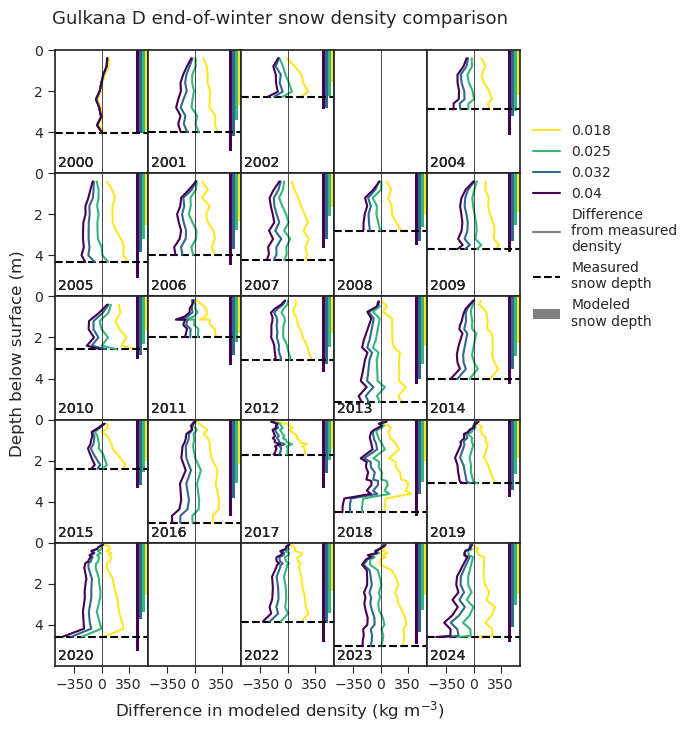

In [68]:
years = np.arange(2000,2025)
fig,axes = plt.subplots(5,5,figsize=(6,8),sharex=True,sharey=True,gridspec_kw={'hspace':0,'wspace':0})
axes = axes.flatten()
norm = mpl.colors.Normalize(vmin=0,vmax=3)
cmap = mpl.colormaps.get_cmap('viridis_r')
# colors = ['#735DEE','#DE217D','#FF5F01','#FFB00D']
# for ss,site in enumerate(site_profiles):
#     # color = cmap(norm(ss))
#     color = colors[ss]
for site in ['D']:
    for cc,c5 in enumerate(longdict[site]):
        # color = colors[cc]
        color = cmap(norm(cc))
        # ds,s,e =  getds(f'../Output/EB/11_04/Gulkana_2024_11_04_long{site}_2.nc')
        # ds = dsdict[site]['0-2']['0.018']['3']
        ds = longdict[site][c5]
        profiles = site_profiles[site]
        for y,year in enumerate(years):
            ax = axes[y]
            if year in profiles['sbd']:
                sample_date = profiles['date'][year]
                dsyear = ds.sel(time=pd.to_datetime(f'{year}-{sample_date}'))
                lheight = dsyear.layerheight.values
                ldepth = np.array([np.sum(lheight[:i+1])-(lheight[i]/2) for i in range(len(lheight))])
                ldensity = dsyear['layerdensity'].values
                interp_density = np.interp(profiles['sbd'][year],ldepth,ldensity)
                diff = interp_density - profiles['density'][year]
                # ax.plot(diff,profiles['sbd'][year],color=cmap(norm(ss)))
                ax.set_title('')
                ax.text(-560,5.7,str(year),fontsize=10)
                snow_idx = np.where(ldepth < dsyear.snowdepth.values)[0]

                # plot_meas_density = np.append(profiles['density'][year],900)
                # plot_meas_depth = np.append(profiles['sbd'][year],profiles['sbd'][year][-1])
                # plot_model_density = np.append(ldensity[snow_idx],900)
                # plot_model_depth = np.append(ldepth[snow_idx],ldepth[snow_idx[-1]])
                plot_meas_density = profiles['density'][year]
                plot_meas_depth = profiles['sbd'][year]
                plot_model_density = ldensity[snow_idx]
                plot_model_depth = ldepth[snow_idx]

                ax.plot(diff,plot_meas_depth,color=color)
                # ax.plot(plot_model_density,plot_model_depth,color=color)
                # ax.plot(plot_meas_density,plot_meas_depth,color=color,linestyle=':')
                snowdepth_mod = ldepth[snow_idx[-1]]
                snowdepth_pit = profiles['sbd'][year][-1]
                ggg=-2
                while np.isnan(snowdepth_pit):
                    snowdepth_pit = profiles['sbd'][year][ggg]
                    ggg -= 1
                ax.bar(600-(cc+1)*40,snowdepth_mod,width=40,color=color,align='edge')
                if cc == 0:
                    # ax.bar(575,snowdepth_pit,width=25,color='black')
                    ax.plot([-600,600],[snowdepth_pit,snowdepth_pit],color='black',linestyle='--')

        axes[4].plot(np.nan,np.nan,label=c5,color=color)
    
    # axes[4].plot(np.nan,np.nan,label=site,color=color)
axes[4].plot(np.nan,np.nan,label='Difference\nfrom measured\ndensity',color='grey')
axes[4].plot(np.nan,np.nan,color='black',linestyle='--',label='Measured\nsnow depth')
axes[4].bar(np.nan,np.nan,color='gray',label='Modeled\nsnow depth')
# axes[4].plot(np.nan,np.nan,label='Measured',linestyle=':',color='grey')
for a,ax in enumerate(axes):
    ax.invert_yaxis()
    ax.set_ylim(6,0)
    ax.set_yticks([0,2,4])
    ax.tick_params(length=5,labelsize=10)
    ax.set_xlim(-600,600)
    ax.set_xticks([-350,0,350])
    if a % 5 != 0:
        ax.tick_params('y',length=0)
    # ax.set_xlim(150,900)
    # ax.set_xticks([250,500,750])
    ax.axvline(0,linewidth=0.5,color='black')
fig.supxlabel('Difference in modeled density (kg m$^{-3}$)',fontsize=12,y=0.04)
fig.supylabel('Depth below surface (m)',fontsize=12,x=0.05)
# axes[0].legend(bbox_to_anchor=(5.6,0.65))
axes[4].legend(bbox_to_anchor=(1,0.5))
fig.suptitle(f'Gulkana {site} end-of-winter snow density comparison',fontsize=13,y=0.93)
# plt.show()
plt.savefig(f'../Output/EB/gulkana{site}_pits_modeled.png',dpi=220,bbox_inches='tight')

Compare albedo

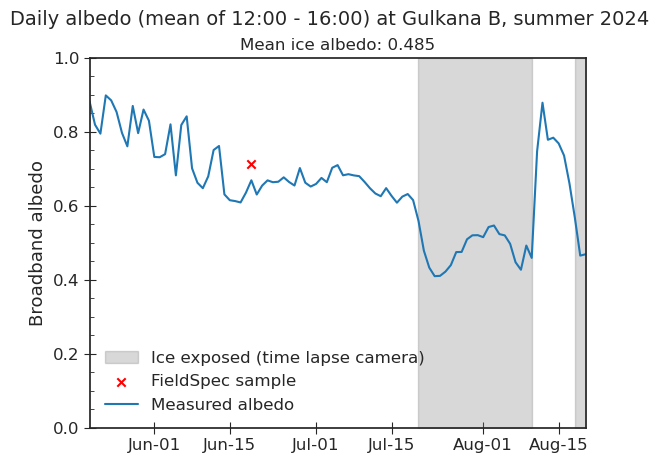

In [91]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/gulkana2024_walbedo.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
daily_albedo = []
ice_albedo = []
dates = pd.date_range('2024-05-20','2024-08-20',freq='d')
dates_ice = np.concatenate([pd.date_range('2024-07-20','2024-08-10'),pd.date_range('2024-08-18','2024-08-22')])
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
    if date in dates_ice:
        ice_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots()
ax.fill_betweenx(y,[pd.to_datetime('2024-08-10')],[pd.to_datetime('2024-07-20')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='red',label='FieldSpec sample')
ax.plot(dates,daily_albedo,label='Measured albedo')

ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(which='major',labelsize=12,length=8,direction='inout')
ax.minorticks_on()
ax.tick_params(axis='x',which='minor',bottom=False)
ax.tick_params(axis='y',which='minor',length=3,direction='in')
ax.legend(fontsize=12)
ax.set_ylabel('Broadband albedo',fontsize=13)
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.set_title(f'Mean ice albedo: {np.mean(ice_albedo):.3f}',fontsize=12)
fig.suptitle('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=14)
plt.savefig('/home/claire/research/climate_data/AWS/gulkana_albedo_2024.png',dpi=150,bbox_inches='tight')
plt.show()
print()

KeyError: "No variable named 'albedo'. Variables on the dataset include ['melt', 'refreeze', 'runoff', 'accum', 'snowdepth', ..., 'layerdust', 'layergrainsize', 'layerrefreeze', 'time', 'layer']"

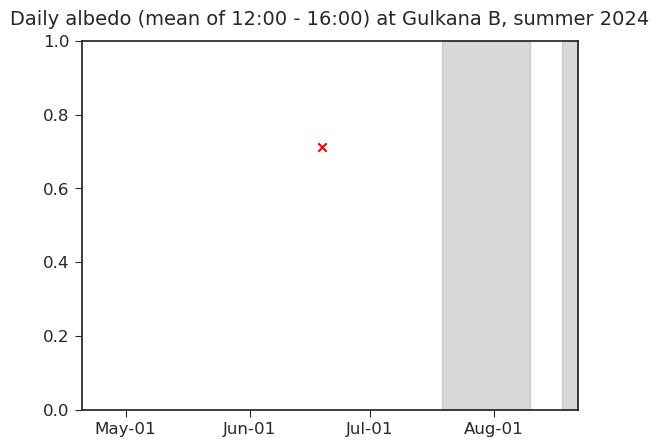

In [69]:
df = pd.read_csv('/home/claire/research/climate_data/AWS/Preprocessed/CLAWS_2024_allvars.csv',index_col=0)
df.index = pd.to_datetime(df.index) # - pd.Timedelta(hours=8)
# df['albedo'] = df['SWout'] / df['SWin']
daily_albedo = []
dates = pd.date_range('2024-04-20','2024-08-22',freq='d')
for date in dates:
    start = pd.to_datetime(str(date.date())+' 12:00')
    end = pd.to_datetime(str(date.date())+' 16:00')
    # print(df.loc[start:end,'albedo'].values)
    daily_albedo.append(np.mean(df.loc[start:end,'albedo']))
y = np.arange(0,1.1,0.1)
fig,ax = plt.subplots()
ax.fill_betweenx(y,[pd.to_datetime('2024-07-19')],[pd.to_datetime('2024-08-10')],color='grey',alpha=0.3,label='Ice exposed (time lapse camera)')
ax.fill_betweenx(y,[pd.to_datetime('2024-08-18')],[pd.to_datetime('2024-08-22')],color='grey',alpha=0.3)
ax.scatter(pd.to_datetime('2024-06-19'),0.7123,marker='x',color='red',label='FieldSpec sample')
ax.set_xlim(dates[0],dates[-1])
ax.set_ylim(0,1)
ax.tick_params(labelsize=12)
ax.set_xticks(pd.date_range(dates[0],dates[-1],freq='MS'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b-%d'))
ax.set_title('Daily albedo (mean of 12:00 - 16:00) at Gulkana B, summer 2024',fontsize=14,y=1.02)
plt.tick_params(size=5)
dsp = bds.sel(time=pd.date_range('2024-04-20 14:00','2024-08-19 14:00'))
ax.plot(dsp.time,dsp['albedo'],label='Modeled')
ax.plot(dates,daily_albedo,label='Measured',linestyle='--')
ax.legend(fontsize=12)
plt.show()
# plt.savefig('/home/claire/research/Output/EB/albedo_modeled_11_05.png',dpi=150,bbox_inches='tight')


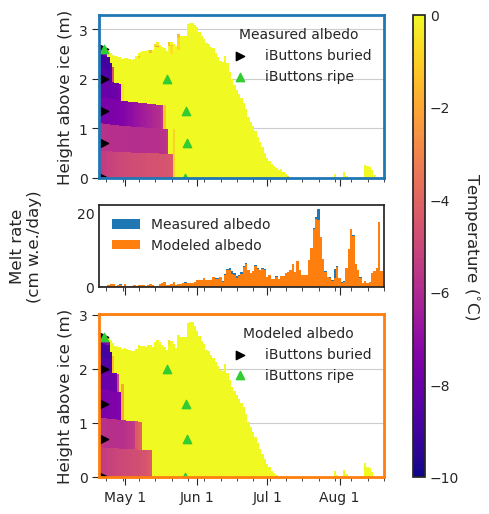

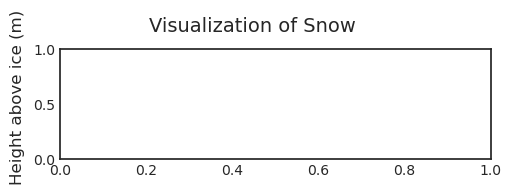

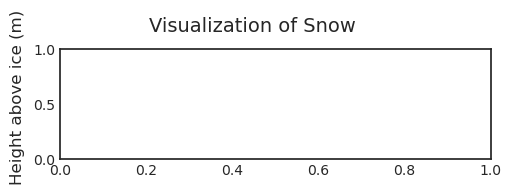

In [98]:
ripe_dict = {'AU': {10: pd.Timestamp('2024-04-21 22:45:00'), 40: pd.Timestamp('2024-04-26 05:30:00'), 80: pd.Timestamp('2024-05-01 14:30:00'), 150: pd.Timestamp('2024-04-27 14:30:00')}, 'B': {10: pd.Timestamp('2024-04-21 21:15:00'), 70: pd.Timestamp('2024-05-18 20:15:00'), 135: pd.Timestamp('2024-05-27 08:45:00'), 200: pd.Timestamp('2024-05-27 11:30:00'), 270: pd.Timestamp('2024-05-26 18:30:00')}, 'D': {10: pd.Timestamp('2024-06-01 18:00:00'), 40: pd.Timestamp('2024-06-02 14:15:00'), 80: pd.Timestamp('2024-06-02 16:45:00'), 120: pd.Timestamp('2024-06-05 14:00:00'), 150: pd.Timestamp('2024-06-05 08:45:00')}}
fig = plt.figure(figsize=(4.2,6))
mosaic = """
        AD
        BD
        CD
"""
ax_dict = fig.subplot_mosaic(mosaic,height_ratios=[2,1,2],width_ratios=[1,0.04])
labels = ['Measured albedo','Modeled albedo']
site = 'B'
for id in [0,1]:
    ripe_dates = {}
    iidd = 0 if id == 1 else 1
    ds,s,e = getds(f'../Output/EB/Gulkana_11_13_2024B_{iidd}.nc')
    nnn = 0 if id == 0 else 2
    ax_letter = 'A' if id == 0 else 'C'
    if site =='D':
        ax_dict[ax_letter] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],ylim=10,plot_ax=[ax_dict[ax_letter]],colorbar=False)[0]
    else:
        ax_dict[ax_letter] = visualize_layers(ds,pd.date_range('2024-04-20','2024-08-20'),['layertemp'],plot_ax=[ax_dict[ax_letter]],colorbar=False)[0]
    ax = ax_dict[ax_letter]

    # Scatter initial heights of iButtons
    depths = np.array([f for f in ripe_dict[site]])
    heights = depths[-1] - depths
    start = np.array([pd.to_datetime('2024-04-22') for _ in range(len(heights))])
    if site == 'D':
        heights += 1200
    ax.scatter(start,heights/100,color='black',marker='>',label='iButtons buried')
    
    # Scatter ripened dates for each sensor
    for depth in ripe_dict[site]:
        if site != 'B':
            height = 150 - depth
        else:
            height = 270 - depth
        if site == 'D':
            height += 1200
        ax.scatter(ripe_dict[site][depth],height/100,marker='^',color='limegreen')
    ax.scatter(np.nan,np.nan,marker='^',color='limegreen',label='iButtons ripe')

    # Add melt rates
    ds = ds.resample(time='d').sum()
    ax_dict['B'].bar(ds.time.values,ds.melt.values*100,label=labels[id],width=pd.Timedelta(hours=25),color=plt.cm.tab10(id))
    ax_dict['B'].set_ylabel('Melt rate\n(cm w.e./day)',fontsize=12,x=-2)
    ax_dict['B'].yaxis.set_label_coords(-0.2,0.5)
    ax_dict['B'].legend(fontsize=10)
    ax.legend(title=labels[id])
    ax.yaxis.grid(True)
    ax.set_ylabel('Height above ice (m)',fontsize=12)
    for spine in ax.spines.values():
        spine.set_edgecolor(plt.cm.tab10(id))
        spine.set_linewidth(2)
    
for aaa in ['A','B','C']:
    ax = ax_dict[aaa]
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d-%b'))
    ax.tick_params(axis='x',which='major', direction='out', length=6)
    ax.minorticks_on()
    ax.set_xticks(pd.date_range('2024-04-20','2024-08-20',freq='MS'))
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.tick_params(axis='y',which='minor',bottom=False)
    ax.xaxis.set_minor_locator(mpl.dates.WeekdayLocator(interval=1))
    ax.tick_params(axis='x',which='minor', direction='out', length=3)
    ax.set_xticklabels([])
ax_dict['C'].set_xticklabels(['May 1','Jun 1','Jul 1','Aug 1'])
sm = mpl.cm.ScalarMappable(cmap='plasma',norm=plt.Normalize(-10,0))
cb = fig.colorbar(sm,aspect=7,fraction=0.02,orientation='vertical',cax=ax_dict['D'])
cb.set_label('Temperature ($^{\circ}$C)',rotation=270,labelpad=15,fontsize=12)
# plt.show()
fig.savefig('../Output/EB/snow_ripening.png',dpi=180,bbox_inches='tight')

Site B internal acc: 0.00027 m w.e.


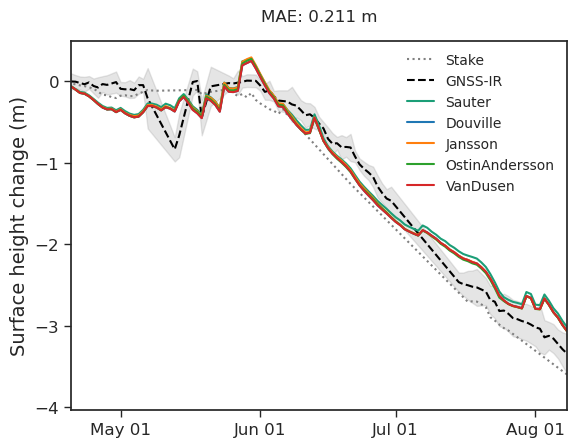

In [38]:
site = 'B'
fig,ax = plt.subplots()
for i in range(5):
    ds,s,e = getds(f'../Output/EB/gridsearch_11_06_B_set{i}_run0_3.nc')
    ksnow = ds.attrs['k_snow']
    if i == 0:
        ax,_ = cumulative_mass_balance(site,ds,plot=True,plot_ax=ax,label='Sauter')
    else:
        ds.dh.values = ds.dh.cumsum().values - ds.dh.isel(time=0).values
        dh = ds.sel(time=pd.date_range('2024-04-20','2024-08-20')).dh
        ax.plot(dh.time,dh.values,label=ksnow)
    ax.legend()

ACTUAL CALIBRATION

In [2]:
# Set up dictionary to store outputs
sitedict = {'2024':['AB','ABB','B','BD','D','T'],
         'long':['A','B','D']}
dsdict = {}

# Set the parameters we want to examine
params = {'kw':[1,2,2.5,3,4],
          'Boone_c5':[0.018,0.025,0.032],
          'kp':[2,2.5,3,3.5,4]}

# Transform params to strings for comparison
for key in params:
    for v,value in enumerate(params[key]):
        params[key][v] = str(value)

# Create nested dictionary
for run in ['2024','long']:
    dsdict[run] = {}
    sites = sitedict[run]
    for site in sites:
        dsdict[run][site] = {}
        for kw in params['kw']:
            dsdict[run][site][kw] = {}
            for c5 in params['Boone_c5']:
                dsdict[run][site][kw][c5] = {}
                for kp in params['kp']:
                    dsdict[run][site][kw][c5][kp] = {}

In [ ]:
# PARSE 2024 RUNS
date = '11_12'
path_out = f'/home/claire/research/Output/EB/'
method = 'MAE'
for i in range(103):
    for j in range(6):
        try:
            fn = f'{date}/grid_{date}_set{i}_run{j}_0.nc'
            ds,startdate,enddate = getds(path_out+fn)
            kp = ds.attrs['kp']
            c5 = ds.attrs['c5']
            kw = ds.attrs['kw']
            site = ds.attrs['site']
            error = cumulative_mass_balance(site,ds,method=method)
            if kp in params['kp'] and kw in params['kw'] and c5 in params['Boone_c5']:
                dsdict['2024'][site][kw][c5][kp]['ds'] = ds
                dsdict['2024'][site][kw][c5][kp][method] = error
        except FileNotFoundError:
            continue
        # except KeyError:
        #     print(kp,c5,kw,site,fn)

In [5]:
# PARSE LONG RUNS
for i in range(103):
    for j in range(6):
        fn = f'11_08_1/grid_11_08_set{i}_run{j}_0.nc'
        try:
            ds,startdate,enddate = getds(path_out+fn)
            kp = ds.attrs['kp']
            c5 = ds.attrs['c5']
            kw = ds.attrs['kw']
            site = ds.attrs['site']
            winter,summer = seasonal_mass_balance(site,ds,method=method)
            if kp in params['kp'] and kw in params['kw'] and c5 in params['Boone_c5']:
                dsdict['long'][site][kw][c5][kp]['ds'] = ds
                dsdict['long'][site][kw][c5][kp]['winter'+method] = winter
                dsdict['long'][site][kw][c5][kp]['summer'+method] = summer
        except FileNotFoundError:
            continue

In [81]:
# See what's missing
missing_2024 = 0
missing_long = 0

for kw in params['kw']:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            for site in sitedict['2024']:
                try:
                    fff = dsdict['2024'][site][kw][c5][kp]['ds']
                except:
                    # print('Missing 2024 runs',site,str(kw),str(c5),str(kp))
                    try:
                        ds = dsdict['2024'][site][kw][c5][kp][method] 
                        err = cumulative_mass_balance(site,ds,method)
                        dsdict['2024'][site][kw][c5][kp][method] = summer
                    except:
                        missing_2024 += 1
            for site in sitedict['long']:
                try:
                    fff = dsdict['long'][site][kw][c5][kp]['summer'+method]
                except:
                    try:
                        ds = dsdict['long'][site][kw][c5][kp]['ds'] 
                        summer,winter = seasonal_mass_balance(site,ds,method)
                        dsdict['long'][site][kw][c5][kp]['summer'+method] = summer
                        dsdict['long'][site][kw][c5][kp]['winter'+method] = winter
                    except:
                        # print('Missing long runs',site,str(kw),str(c5),str(kp))
                        missing_long += 1
print(f'Missing {missing_2024} 2024 runs and {missing_long} long runs')

Missing 0 2024 runs and 10 long runs


In [6]:
labels = {'kp':'Precipitation factor','kw':'Wind factor','Boone_c5':'Densification c$_5$'}
methodlabels = {'MAE':'MAE','ME':'Absolute Mean Bias','RMSE':'RMSE'}
medians = {'kp':'2.5','kw':'1','Boone_c5':'0.025'}
all_sites = sitedict['long']+sitedict['2024']+['mean']

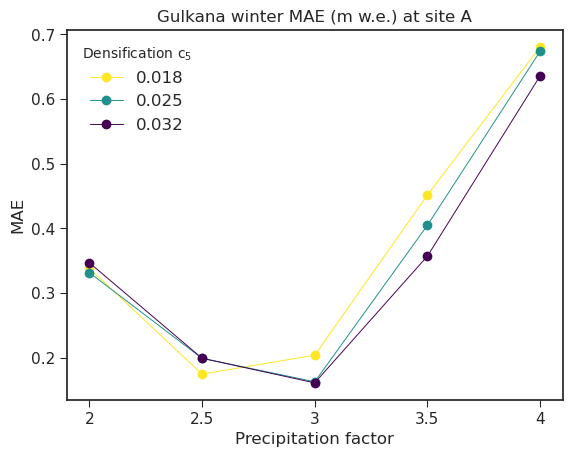

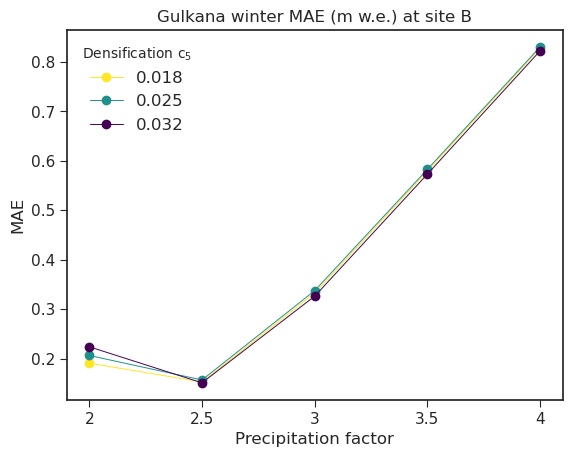

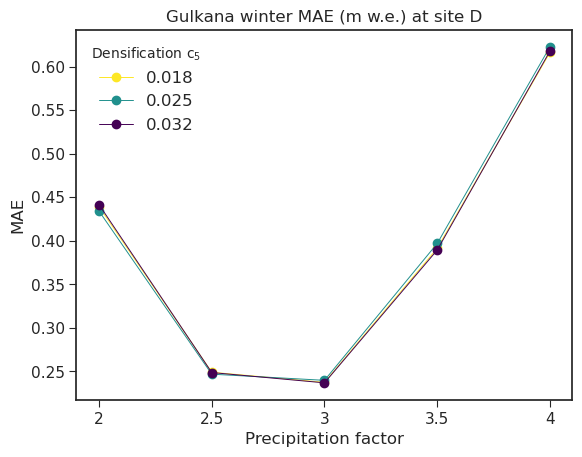

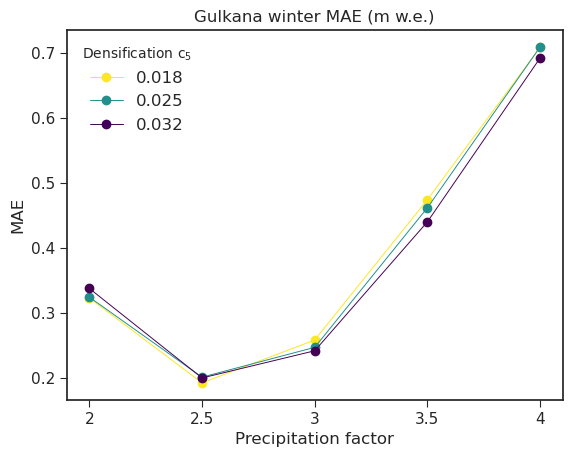

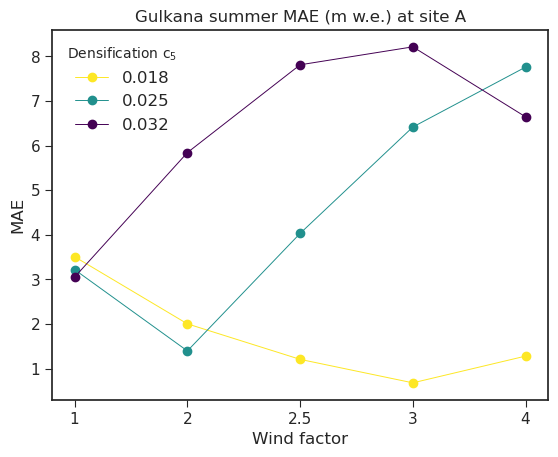

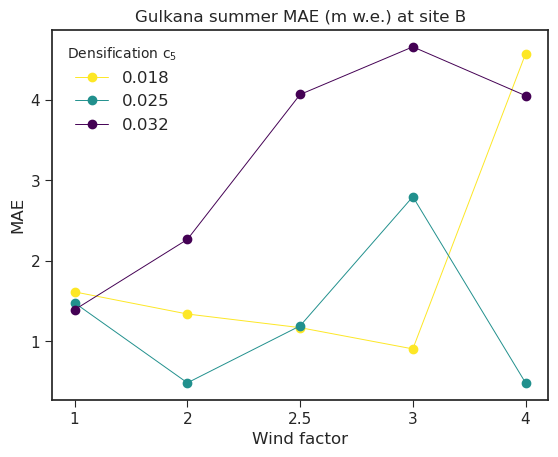

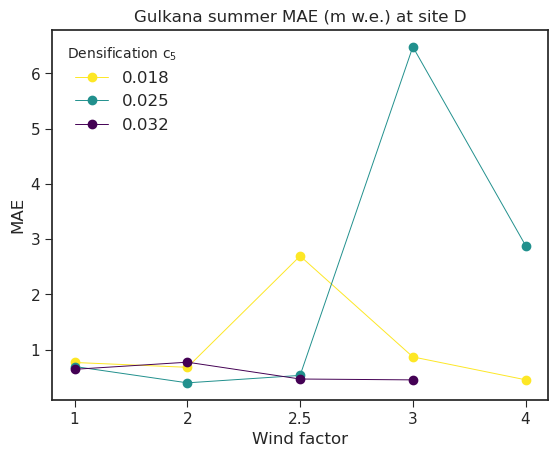

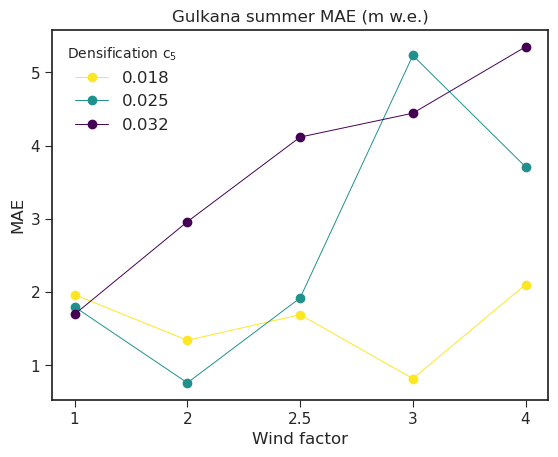

In [10]:
# run_name = '2024' # '2024','winter', or 'summer' 
for run_name in ['winter','summer']: # '2024','winter',
    # Parse run info
    run = '2024' if run_name == '2024' else 'long'
    if run == 'long':
        err_name = run_name + method
    else:
        err_name = method
    
    if run_name == '2024':
        param_x = 'kp'
        param_z = 'Boone_c5'
    elif run_name == 'winter':
        param_x = 'kp'
        param_z = 'Boone_c5'
    elif run_name == 'summer':
        param_x = 'kw'
        param_z = 'Boone_c5'
    
    all_sites = sitedict[run]+['mean']

    for site in all_sites:
        fig,ax = plt.subplots()
        param_x_arr = np.array(params[param_x],dtype=str)
        param_z_arr = np.array(params[param_z],dtype=str)
        errors = np.empty([len(param_x_arr),len(param_z_arr)])

        if 'kw' not in [param_x,param_z]:
            kw = medians['kw']
        if 'kp' not in [param_x,param_z]:
            kp = medians['kp']
        if 'Boone_c5' not in [param_x,param_z]:
            c5 = medians['Boone_c5']

        norm = mpl.colors.Normalize(vmin=0,vmax=len(param_z_arr)-1)
        cmap = mpl.colormaps.get_cmap('viridis_r')
        for zz,zval in enumerate(param_z_arr):
            for xx,xval in enumerate(param_x_arr):
                if param_x == 'kw':
                    kw = xval
                elif param_z == 'kw':
                    kw = zval
                if param_x == 'kp':
                    kp = xval
                elif param_z == 'kp':
                    kp = zval
                if param_x == 'Boone_c5':
                    c5 = xval
                elif param_z == 'Boone_c5':
                    c5 = zval

                if site == 'mean':
                    site_vals = []
                    for s in sitedict[run]:
                        if err_name in dsdict[run][s][kw][c5][kp]:
                            site_vals.append(dsdict[run][s][kw][c5][kp][err_name])
                        else:
                            site_vals.append(np.nan)
                    errors[xx,zz] = np.nanmean(site_vals)
                else:
                    if site in sitedict[run] and err_name in dsdict[run][site][kw][c5][kp]:
                        errors[xx,zz] = dsdict[run][site][kw][c5][kp][err_name]
                    else:
                        errors[xx,zz] = np.nan
            errors = np.abs(errors)
            ax.plot(param_x_arr,errors[:,zz],color=cmap(norm(zz)),label=str(zval),marker='o',linewidth=0.7)
        ax.legend(title=labels[param_z],fontsize=12)
        ax.set_xlabel(labels[param_x],fontsize=12)
        ax.set_ylabel(method,fontsize=12)
        units = 'm w.e.' if run == 'long' else 'm'
        title = f'Gulkana {run_name} {methodlabels[method]} ({units})'
        if site != 'mean':
            title += f' at site {site}'
        ax.set_title(title)
        ax.tick_params(length=5,labelsize=11)
        plt.savefig(f'../Output/EB/{param_z}_vs_{param_x}_{run_name}_{site}.png')
        plt.show()

In [87]:
min_err = np.inf
min_long_err = np.inf
min_2024_err = np.inf
method = 'MAE'
for kw in params['kw']:
    for c5 in params['Boone_c5']:
        for kp in params['kp']:
            summer = []
            winter = []
            s24 = []
            # Find mean long run error across sites and seasons
            for site in sitedict['long']:
                if 'summer'+method in dsdict['long'][site][kw][c5][kp]:
                    summer.append(np.abs(dsdict['long'][site][kw][c5][kp][f'summer{method}']))
                    winter.append(np.abs(dsdict['long'][site][kw][c5][kp][f'winter{method}']))
            meanlong = np.mean([np.array(summer),np.array(winter)]) # 
            if meanlong < min_long_err:
                min_long_err = meanlong
                best_long = [kw,c5,kp]
            # Find mean short run error across sites
            for site in sitedict['2024']:
                if method in dsdict['2024'][site][kw][c5][kp]:
                    s24.append(np.abs(dsdict['2024'][site][kw][c5][kp][method]))
            mean24 = np.mean(s24)
            if mean24 < min_2024_err:
                min_2024_err = mean24
                best_2024 = [kw,c5,kp]
            # Find best overall error
            err = np.mean([meanlong,mean24])
            if err < min_err:
                min_err = err
                best = [kw,c5,kp]
print(best,min_err,min_long_err,min_2024_err)
kw,c5,kp = best

['1', '0.032', '2.5'] 0.563751296277585 0.5737567849180155 0.17924310389470752


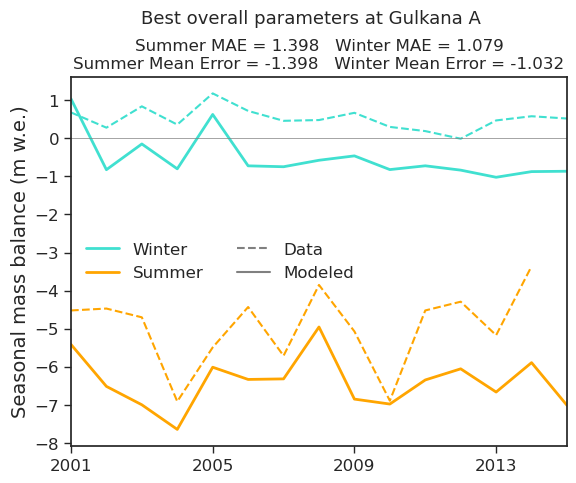

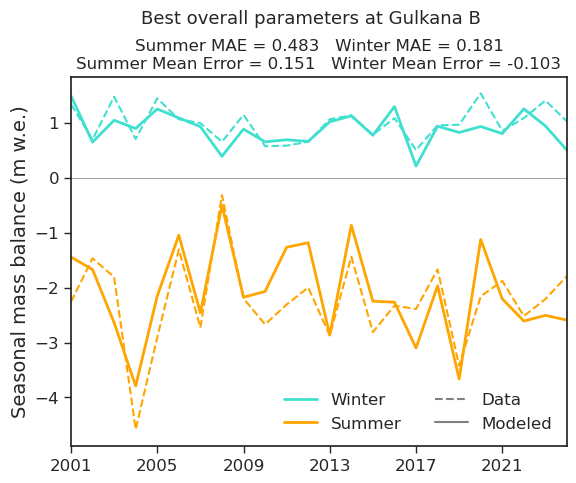

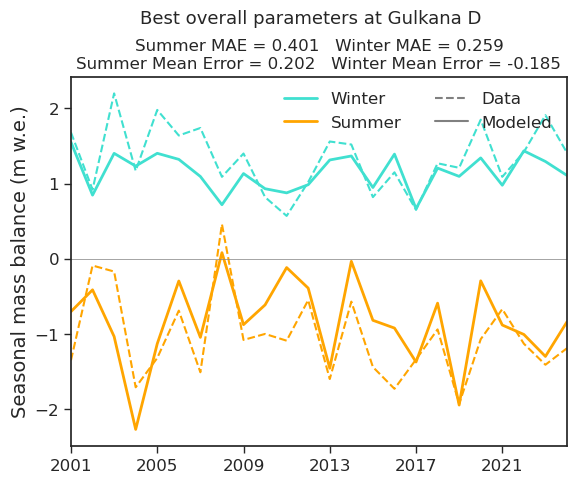

In [12]:
for site in sitedict['long']:
    ds = dsdict['long'][site]['2']['0.025']['2.5']['ds']
    fig,ax = seasonal_mass_balance(site,ds,plot=True)
    fig.suptitle(f'Best overall parameters at Gulkana {site}',y=1.02,fontsize=13)

Site AB internal acc: 0.00016 m w.e.
Site AB internal acc: 0.00016 m w.e.
Site B internal acc: 0.00015 m w.e.
Site B internal acc: 0.00015 m w.e.
Site D internal acc: 0.07801 m w.e.
Site D internal acc: 0.07801 m w.e.
Site T internal acc: 0.09136 m w.e.
Site T internal acc: 0.09136 m w.e.


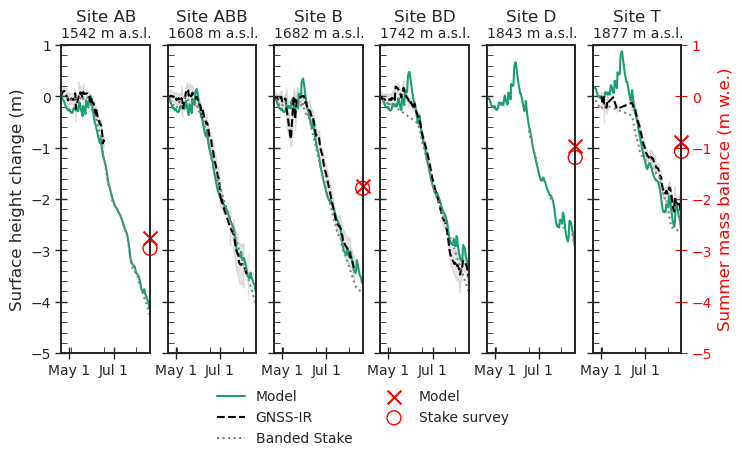

In [30]:
kw,c5,kp = ['1','0.032','2.5'] # best
elev = {'AB':1542,'ABB':1608,'B':1682,'BD':1742,'D':1843,'T':1877}
ylim = (-5,1)
fig,axes = plt.subplots(1,6,figsize=(8,4),sharey=True,sharex=True,gridspec_kw={'wspace':0.2})
for i,site in enumerate(['AB','ABB','B','BD','D','T']):
# for i, site in enumerate(['B','D']):
    # ds,startdate,enddate = getds(f'../Output/EB/Gulkana_11_11_2024{site}_{id}.nc')
    # ds = dsdict['2024']['B']['2']['0.025']['2.5']['ds']
    ds = dsdict['2024'][site][kw][c5][kp]['ds']
    if site == 'B':
        bds = ds.copy(deep=True)
    axes[i],error = cumulative_mass_balance(site,ds,plot_ax=axes[i])
    axes[i].set_title(f'Site {site}',fontsize=12,y=1.05)
    axes[i].text(pd.to_datetime('2024-04-20'),1.15,str(elev[site])+' m a.s.l.',fontsize=10)
    axes[i].set_ylabel('')
    # direction = '' if error < 0 else '+'
    # text = f'{direction}{error:.3f} m'
    # axes[i].text(enddate-pd.Timedelta(days=80),0.9,text,fontsize=10)
    axes[i].get_legend().remove()
    axes[i].set_xlim(startdate,enddate)
    axes[i].set_xticks(pd.date_range(startdate,enddate,freq='2MS'))
    axes[i].tick_params(labelsize=10,direction='inout',length=8)
    axes[i].minorticks_on()
    axes[i].tick_params(which='minor', direction='in', length=4)
    axes[i].set_xticklabels(['May 1','Jul 1'])
    axes[i].xaxis.set_minor_locator(mpl.dates.DayLocator(interval=45))
    twinax = axes[i].twinx()
    if site not in ['ABB','BD']:
        mbmod,mbmeas = cumulative_mass_balance(site,ds,out_mbs=True)
        mod = twinax.scatter(enddate,mbmod,color='red',marker='x',s=100)
        meas = twinax.scatter(enddate,mbmeas,color='red',marker='o',facecolors='none',s=100)
        meas.set_clip_on(False)
        mod.set_clip_on(False)
    twinax.set_ylim(ylim)
    twinax.yaxis.set_ticks_position('right')
    if site=='T':
        twinax.tick_params(labelright=True,labelsize=10,direction='inout',length=8,labelcolor='red',colors='red')
        twinax.set_ylabel('Summer mass balance (m w.e.)',fontsize=12,color='red')
    else:
        twinax.set_yticklabels([])
for ax in axes:
    ax.set_xlim(pd.to_datetime('2024-04-20'),pd.to_datetime('2024-08-20'))
    ax.set_ylim((ylim))
axes[0].set_ylabel('Surface height change (m)',fontsize=12)
l1, = axes[-1].plot(np.nan,np.nan,color=plt.cm.Dark2(0))
l2, = axes[-1].plot(np.nan,np.nan,color='black',linestyle='--')
l3, = axes[-1].plot(np.nan,np.nan,color='gray',linestyle=':')
leg = fig.legend([l1,l2,l3,mod,meas],['Model','GNSS-IR','Banded Stake','Model','Stake survey'],ncols=2,fontsize=10,bbox_to_anchor=(0.7,0.05))
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(1)
plt.savefig(f'/home/claire/research/Output/EB/gulkana_dh_best_params.png',dpi=180,bbox_inches='tight')
plt.show()

In [53]:
print(best,best_2024)

['1', '0.025', '3'] ['1', '0.032', '2.5']


In [234]:
path_out = '/home/claire/research/Output/calibration/09_24/'

# Parameter sets
aa = [0.2,0.4,0.6]
ww = [0.25,0.5,0.75,1]
kk = ['Sturm','Douville','Jansson'] #,'OstinAndersson','VanDusen']
params_dict = {'kw':ww,'k_snow':kk,'a_ice':aa} # 'kw':ww,

# Get the lengths of each parameter list for the result array shape
shape = [len(v) for v in params_dict.values()]

# Initialize result arrays with a dimension for site (3 sites + 1 for the average)
winter_result = np.ones([4] + shape)
summer_result = np.ones([4] + shape)

# Initialize lists for storing the parameters
params_list = {key: [] for key in params_dict}

# Generate combinations of all parameters
all_combos = itertools.product(*params_dict.values())
for idx, param_values in enumerate(all_combos):
    # Unpack indices
    indices = np.unravel_index(idx, shape)

    # Store parameter set
    for param_name, param_value in zip(params_dict.keys(), param_values):
        params_list[param_name].append(param_value)
    
    # Iterate over sites
    for s, site in enumerate(['AB', 'B', 'D']):
        kw = 0.25 if site == 'D' else 1
        fn = f'kw{kw}_'

        # fn = ''
        for param_name, param_value in zip(params_dict.keys(), param_values):
            fn += param_name.replace('_','')+str(param_value)+'_'
        fn += f'site{site}_0.nc'

        try:
            ds, startdate, enddate = getds(path_out + fn)
            winter, summer = seasonal_mass_balance(data_fp, ds, site=site, method='MAE')
        except:
            winter, summer = (np.nan, np.nan)
            print(fn + ' does not exist')
        
        # Store results in the corresponding array
        winter_result[s][indices] = winter
        summer_result[s][indices] = summer

    # Compute site averages and store in the last index (3rd index in the result arrays)
    winter_result[3][indices] = np.mean(winter_result[:3,*indices])
    summer_result[3][indices] = np.mean(summer_result[:3,*indices])